This NB demonstrates the xcube **SMOS L2C data store `smos`** using a *dataset iterator*.

In [1]:
import itertools
import json

from IPython.display import JSON
import matplotlib.pyplot as plt
import xarray as xr

from xcube.core.store import find_data_store_extensions
from xcube.core.store import get_data_store_params_schema
from xcube.core.store import new_data_store

In [2]:
# import dask.distributed
# dask.distributed.Client(processes=False, n_workers=4)

Which data stores are available? The data store `smos` should be among them!

In [3]:
JSON({e.name: e.metadata for e in find_data_store_extensions()})

<IPython.core.display.JSON object>

Which parameters are supported by the `smos` data store?

In [4]:
get_data_store_params_schema("smos")

Create a store instance. Load our CreoDIAS credentials first.

In [5]:
with open("creodias-credentials.json") as f:
    credentials = json.load(f)

In [6]:
store = new_data_store(
    "smos",
    source_path="s3://EODATA",
    source_storage_options=dict(
        endpoint_url="https://s3.cloudferro.com", anon=False, **credentials
    ),
    cache_path="nc_cache",
    xarray_kwargs=dict(
        engine="h5netcdf"
        # engine="netcdf4"
    ),
)

Which parameters are supported if I use the store to open a SMOS datacube?

In [7]:
store.get_open_data_params_schema()

Which dataset types are supported by the `smos` data store?

In [8]:
JSON(store.list_data_ids())

<IPython.core.display.JSON object>

In [9]:
store.get_data_opener_ids()

('dataset:zarr:smos', 'mldataset:zarr:smos', 'smosdsiter:zarr:smos')

Lets try the opener `"smosdsiter:zarr:smos"` that will provide an iterator of xarray datasets:

In [30]:
ds_iter = store.open_data(
    "SMOS-L2C-OS",
    opener_id="smosdsiter:zarr:smos",
    time_range=("2022-01-01", "2022-01-01"),
)

In [31]:
len(ds_iter)

29

In [32]:
ds = next(ds_iter)
ds

<xarray.Dataset>
Dimensions:              (lat: 4032, lon: 8192, time: 1, bnds: 2)
Coordinates:
  * lat                  (lat) float64 88.57 88.53 88.48 ... -88.53 -88.57
  * lon                  (lon) float64 -180.0 -179.9 -179.9 ... 179.9 180.0
  * time                 (time) datetime64[ns] 2022-01-01T00:43:53.718000
    time_bnds            (time, bnds) datetime64[ns] 2022-01-01T00:17:12.8990...
Dimensions without coordinates: bnds
Data variables:
    Dg_quality_SSS_corr  (time, lat, lon) uint16 999 999 999 999 ... 999 999 999
    Sigma_SSS_corr       (time, lat, lon) float32 -999.0 -999.0 ... -999.0
    Dg_RFI_X             (time, lat, lon) uint16 64537 64537 ... 64537 64537
    Dg_RFI_Y             (time, lat, lon) uint16 64537 64537 ... 64537 64537
    SSS_anom             (time, lat, lon) float32 -999.0 -999.0 ... -999.0
    Mean_acq_time        (time, lat, lon) float32 -999.0 -999.0 ... -999.0
    Dg_chi2_corr         (time, lat, lon) uint16 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    Dg_quality_SSS_anom  (time, lat, lon) uint16 999 999 999 999 ... 999 999 999
    X_swath              (time, lat, lon) float32 -999.0 -999.0 ... -999.0
    SSS_corr             (time, lat, lon) float32 -999.0 -999.0 ... -999.0
    Coast_distance       (time, lat, lon) uint8 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    Sigma_SSS_anom       (time, lat, lon) float32 -999.0 -999.0 ... -999.0
Attributes:
    Precise_Validity_Start:  UTC=2022-01-01T00:17:12.899057
    Precise_Validity_Stop:   UTC=2022-01-01T01:10:34.537454
    Abs_Orbit_Start:         +63930
    Start_Time_ANX_T:        4305.640659
    Abs_Orbit_Stop:          +63931
    Stop_Time_ANX_T:         1502.801444
    UTC_at_ANX:              UTC=2021-12-31T23:05:27.258398
    Long_at_ANX:             +103.959855
    Ascending_Flag:          A
    Polarisation_Flag:       F

In [33]:
for k, v in ds.data_vars.items():
    print(f"| {k} | {v.encoding.get('dtype')} | {v.attrs.get('units')} |")

| Dg_quality_SSS_corr | uint16 | None |
| Sigma_SSS_corr | float32 | psu |
| Dg_RFI_X | uint16 | None |
| Dg_RFI_Y | uint16 | None |
| SSS_anom | float32 | psu |
| Mean_acq_time | float32 | dd |
| Dg_chi2_corr | uint16 | None |
| Dg_quality_SSS_anom | uint16 | None |
| X_swath | float32 | m |
| SSS_corr | float32 | psu |
| Coast_distance | uint8 | None |
| Sigma_SSS_anom | float32 | psu |


In [24]:
ds.Soil_Moisture

<xarray.DataArray 'Soil_Moisture' (time: 1, lat: 4032, lon: 8192)>
dask.array<open_dataset-Soil_Moisture, shape=(1, 4032, 8192), dtype=float32, chunksize=(1, 4032, 8192), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 88.57 88.53 88.48 88.44 ... -88.48 -88.53 -88.57
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * time     (time) datetime64[ns] 2022-01-01T00:43:53.718000
Attributes:
    units:    m3 m-3

In [14]:
var_names = [
    "Soil_Moisture",
    "Soil_Moisture_DQX",
    "Chi_2",
    "Chi_2_P",
    "N_RFI_X",
    "N_RFI_Y",
]

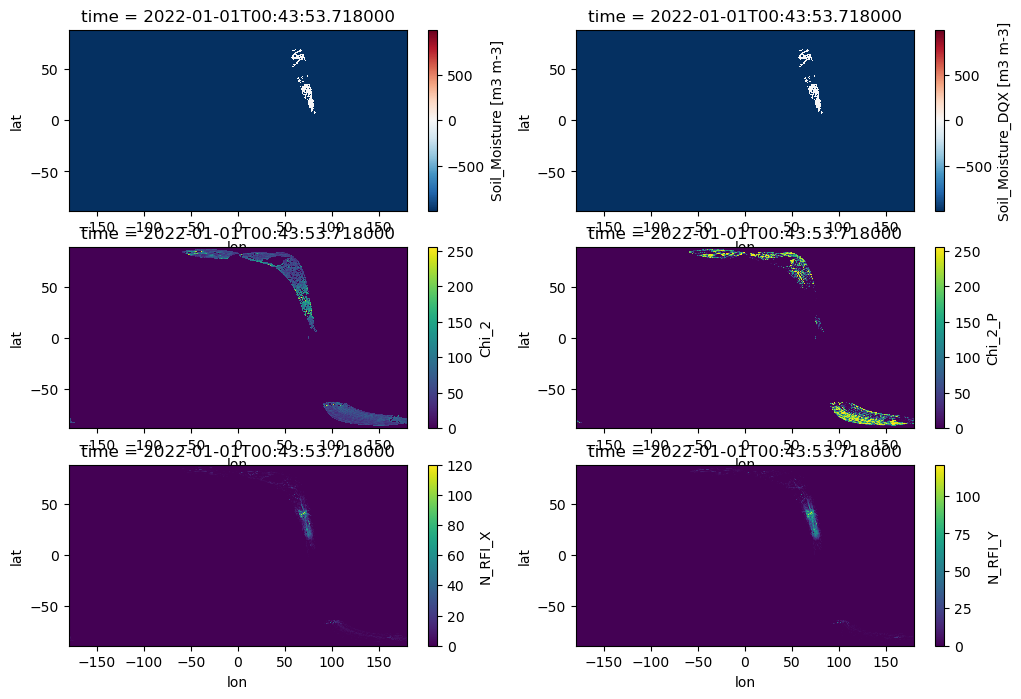

In [15]:
f, axes = plt.subplots(3, 2, figsize=(12, 8))
for index, (ax, var_name) in enumerate(zip(itertools.chain(*axes), var_names)):
    ds[var_name].isel(time=0).plot.imshow(ax=ax)

In [16]:
ds.to_zarr("smos-slice.zarr", mode="w", write_empty_chunks=False)

In [17]:
ds = xr.open_zarr("smos-slice.zarr")
ds

<xarray.Dataset>
Dimensions:            (time: 1, lat: 4032, lon: 8192, bnds: 2)
Coordinates:
  * lat                (lat) float64 88.57 88.53 88.48 ... -88.48 -88.53 -88.57
  * lon                (lon) float64 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * time               (time) datetime64[ns] 2022-01-01T00:43:53.718000
    time_bnds          (time, bnds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    Chi_2              (time, lat, lon) float32 dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    Chi_2_P            (time, lat, lon) float32 dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    N_RFI_X            (time, lat, lon) float32 dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    N_RFI_Y            (time, lat, lon) float32 dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    RFI_Prob           (time, lat, lon) float32 dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    Soil_Moisture      (time, lat, lon) float32 dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    Soil_Moisture_DQX  (time, lat, lon) float32 dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
Attributes:
    Abs_Orbit_Start:         +63930
    Abs_Orbit_Stop:          +63931
    Ascending_Flag:          A
    Long_at_ANX:             +103.959855
    Polarisation_Flag:       F
    Precise_Validity_Start:  UTC=2022-01-01T00:17:12.899057
    Precise_Validity_Stop:   UTC=2022-01-01T01:10:34.537454
    Start_Time_ANX_T:        4305.640659
    Stop_Time_ANX_T:         1502.801444
    UTC_at_ANX:              UTC=2021-12-31T23:05:27.258398

In [18]:
ds.Soil_Moisture

<xarray.DataArray 'Soil_Moisture' (time: 1, lat: 4032, lon: 8192)>
dask.array<open_dataset-Soil_Moisture, shape=(1, 4032, 8192), dtype=float32, chunksize=(1, 4032, 8192), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 88.57 88.53 88.48 88.44 ... -88.48 -88.53 -88.57
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * time     (time) datetime64[ns] 2022-01-01T00:43:53.718000
Attributes:
    units:    m3 m-3

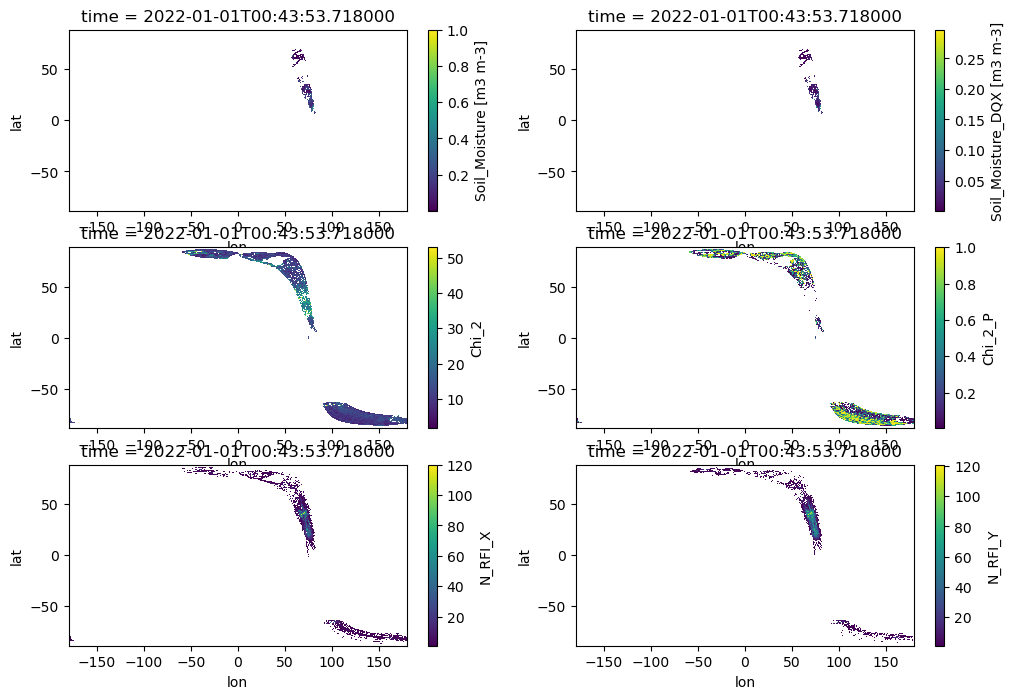

In [19]:
f, axes = plt.subplots(3, 2, figsize=(12, 8))
for index, (ax, var_name) in enumerate(zip(itertools.chain(*axes), var_names)):
    ds[var_name].isel(time=0).plot.imshow(ax=ax)